## Yield Oracles:  Predicting Soybean Yields in Brazil Using Satellite and Weather Data

This code was written as part of a project to satisfy the [Capstone Course](https://datascience.berkeley.edu/academics/curriculum/synthetic-capstone-course/) requirement of the [UC Berkeley Master of Information and Data Science](https://datascience.berkeley.edu) (MIDS) program.  Our project was completed in April 2016.  For more details and to see our results, please visit our [website](http://amitavadas.github.io/capstone/index.html).  We look forward to your feedback!

For questions and comments about this code, please contact the author, Marguerite Oneto, by email at marguerite.oneto@ischool.berkeley.edu.

# Run A Convolutional Neural Network Using Theano
This code is based on a notebook shared in the [W207: Applied Machine Learning](https://datascience.berkeley.edu/academics/curriculum/applied-machine-learning/) course of the MIDS curriculum.  
That notebook was based on the references below.  The code was cleaned up by my Final Project teammate Lei Yang.  

Reference:  http://deeplearning.net/tutorial/lenet.html   
Reference:  http://ufldl.stanford.edu/tutorial/supervised/FeatureExtractionUsingConvolution/   
Reference:  https://www.youtube.com/watch?v=S75EdAcXHKk   
Reference:  http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/   

Data for Yield Prediction Test:  https://github.com/maoneto/W210/blob/master/Code/data/train_cnn_21images_64grids_trunc.csv

# Run 5-Layer CNN Model Using Theano with All 21 Images

## Create training, validation, and test datasets

In [1]:
import math
import csv
import numpy as np
from sklearn.cross_validation import train_test_split

X = []
Y = []

with open('train_cnn_21images_64grids_trunc.csv', 'r') as csvfile:
    datareader = csv.reader(csvfile, delimiter=',')
    for row in datareader:
        label = row.pop()  ## pop the last element in the list which is the label (yield calc)
        X.append(row)
        Y.append(label)
X = np.array(X).astype(np.float)
Y = np.array(Y).astype(np.float)

# Break labeled examples into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=22)

X_train = X_train.reshape(X_train.shape[0], 21, 13, 13)
X_test = X_test.reshape(X_test.shape[0], 21, 13, 13)
Y_train = Y_train.reshape(Y_train.shape[0], 1)
Y_test = Y_test.reshape(Y_test.shape[0], 1)

print "X_train and X_test Shape:"
print X_train.shape, X_test.shape

print "Y_train and Y_test Shape:"
print Y_train.shape, Y_test.shape



X_train and X_test Shape:
(400, 21, 13, 13) (100, 21, 13, 13)
Y_train and Y_test Shape:
(400, 1) (100, 1)


### 5-Layer Convolutional Neural Network Using [Theano](http://www.deeplearning.net/software/theano/)
  - 3 convolution layers (32/64/128 feature maps) with subsampling and 2 globally connected neural layers (600 neurons)
  - Because the convergence process was not smooth, we reduced the learning rate to 0.0001 and saved the predictions for the test data whenever the cost was reduced during an epoch.

In [2]:
import time
import pickle
from datetime import datetime
import theano 
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
from theano.tensor.nnet.conv import conv2d
from theano.tensor.signal.downsample import max_pool_2d
print theano.config.device # We're using CPUs (for now)
print theano.config.floatX # Should be 64 bit for CPUs

theano.exception_verbosity='high'
theano.mode='FAST_COMPILE'
theano.allow_gc=False

cpu
float64


In [3]:
class YieldPredictor():
    
    # Initialize an instance of the class.
    def __init__(self, n_output):
        self._getParameters(n_output)
        self._getModel()

    def _getParameters(self, numClasses):  # initialize weights randomly
        numHiddenNodes = 600
        patchWidth = 3
        patchHeight = 3
        featureMapsLayer1 = 32
        featureMapsLayer2 = 64
        featureMapsLayer3 = 128
        # Convolution layers.
        w_1 = theano.shared(np.asarray((np.random.randn(*(featureMapsLayer1, 21, patchWidth, patchHeight))*0.01)))
        w_2 = theano.shared(np.asarray((np.random.randn(*(featureMapsLayer2, featureMapsLayer1, patchWidth-1, patchHeight-1))*0.01)))
        w_3 = theano.shared(np.asarray((np.random.randn(*(featureMapsLayer3, featureMapsLayer2, patchWidth-1, patchHeight-1))*0.01)))
        # Fully connected NN.
        w_4 = theano.shared(np.asarray((np.random.randn(*(featureMapsLayer3 * 2 * 2, numHiddenNodes))*0.01)))
        w_5 = theano.shared(np.asarray((np.random.randn(*(numHiddenNodes, numClasses))*0.01)))
        self.params = [w_1, w_2, w_3, w_4, w_5]
        self.srng = RandomStreams()

    def _getModel(self):
        theano.config.floatX = 'float64'
        X = T.tensor4() # conv2d works with tensor4 type
        Y = T.matrix()
        
        w_1, w_2, w_3, w_4, w_5 = self.params[0], self.params[1], self.params[2], self.params[3], self.params[4]
        y_hat_train = self._model(X, w_1, w_2, w_3, w_4, w_5, 0.2, 0.5)
        y_hat_predict = self._model(X, w_1, w_2, w_3, w_4, w_5, 0., 0.)

        self.cost = T.sqrt(T.mean(T.sqr(Y - y_hat_train))) # RMSE. Or use SSE = T.sum(T.sqr(Y - y_hat_train))
        update = self._backprop(self.cost, self.params)
        self.train = theano.function(inputs=[X, Y], outputs=self.cost, updates=update, allow_input_downcast=True)
        self.predict = theano.function(inputs=[X], outputs=y_hat_predict, allow_input_downcast=True)

    def _model(self, X, w_1, w_2, w_3, w_4, w_5, p_1, p_2):
        l1 = self._dropout(max_pool_2d(T.maximum(conv2d(X, w_1, border_mode='full'),0.), (2, 2)), p_1)
        l2 = self._dropout(max_pool_2d(T.maximum(conv2d(l1, w_2),0.), (2, 2)), p_1)
        # flatten to switch back to 1d layers - with "outdim = 2" (2d) output 
        l3 = self._dropout(T.flatten(max_pool_2d(T.maximum(conv2d(l2, w_3),0.), (2, 2)), outdim=2), p_1)
        l4 = self._dropout(T.maximum(T.dot(l3, w_4), 0.), p_2)
        return T.dot(l4, w_5)

    def _dropout(self, X, p=0.):
        if p > 0:
            X *= self.srng.binomial(X.shape, p=1 - p)
            X /= 1 - p
        return X

    def _backprop(self, Cost, w, alpha=0.0001, rho=0.66, epsilon=1e-6):
        grads = T.grad(cost=Cost, wrt=w)
        updates = []
        for w1, grad in zip(w, grads):
            # adding gradient scaling
            acc = theano.shared(w1.get_value() * 0.0)
            acc_new = rho * acc + (1 - rho) * grad ** 2
            gradient_scaling = T.sqrt(acc_new + epsilon)
            grad = grad / gradient_scaling
            updates.append((acc, acc_new))
            updates.append((w1, w1 - grad * alpha))
        return updates

    def _shuffleData(self, p, X, y):
        # shuffle it
        shuffle = np.random.permutation(np.arange(X.shape[0]))
        X, y = X[shuffle], y[shuffle]
        # divide 
        n_train = np.round(X.shape[0]*p)
        return X[:n_train], y[:n_train], X[n_train:], y[n_train:] 

    def fit_predict(self, X, y, x_test, y_test, epochs=1000, miniBatchSize=100):
        # Set start of training time
        start_time = time.time()
        # Set model time
        modeltime = datetime.now().strftime("%Y%m%d%H%M%S")
        print 'Epochs: %d, MiniBatchSize: %d, TrainingExamples: %d, ModelTime: %s' %(epochs, miniBatchSize, y.shape[0], modeltime)      
        # Set epoch variables
        min_val_rmse = 100000
        train_losses = []
        val_losses = []
        num_examples_seen = 0
        # Divide the data
        train_data, train_labels, val_data, val_labels = self._shuffleData(0.9, X, y)
        for i in range(epochs):
            epoch_start = time.time()
            # shuffle training data only
            shuffle = np.random.permutation(np.arange(train_data.shape[0]))
            train_data, train_labels = train_data[shuffle], train_labels[shuffle]
            # run mini-batch gradient descent
            for start, end in zip(range(0, len(train_data), miniBatchSize), range(miniBatchSize, len(train_data), miniBatchSize)):
                self.cost = self.train(train_data[start:end], train_labels[start:end])
            epoch_time = time.time() - epoch_start
            # Record training loss
            train_losses.append((i, self.cost))
            # Make predictions on validation dataset
            predicted_labels = self.predict(val_data)
            # Calculate validation cost RMSE
            val_rmse = np.sqrt(np.mean(np.square(predicted_labels - val_labels)))
            val_losses.append((i, val_rmse))
            # if we have a new low val_rmse, save the weights and predictions
            is_saved = ''
            if val_rmse < min_val_rmse:
                min_val_rmse = val_rmse
                # Make and save predictions on test dataset
                predictions = self.predict(x_test)
                predictions_and_labels = np.array(zip(predictions, y_test))
                filename = "./predictions/CNNs/pred-%s.txt" %(modeltime)
                np.savetxt(filename, predictions_and_labels, fmt='%.18f', delimiter=',',)
                # Save model parameters
                filename = "./models/CNNs/CNN-%s.pkl" % (modeltime)
                pickle.dump(self.params, open(filename, 'w'))
                is_saved = '(saved)'
            # print epoch results to screen             
            print '%d) trainCost = %.4f, validationRMSE = %.4f, trainTime = %.2f min, endTime = %s %s' %(i+1, self.cost, val_rmse, epoch_time/60, time.strftime("%I:%M:%S"), is_saved)
            
        print 'Finished.  Total train time = %.2f hours' %((time.time() - start_time)/3600)   
    
        return train_losses, val_losses

print 'Model refreshed @ %s' %(time.strftime("%I:%M:%S"))

Model refreshed @ 11:10:35


In [4]:
################### Option 2. Theano 5-layer Model ###################

net5 = YieldPredictor(n_output=1)
train_losses, val_losses = net5.fit_predict(X=X_train, y=Y_train, x_test=X_test, y_test=Y_test, epochs=10, miniBatchSize=10)
# del net5  # Free up memory

Epochs: 10, MiniBatchSize: 10, TrainingExamples: 400, ModelTime: 20160428111039
1) trainCost = 2.8932, validationRMSE = 2.8432, trainTime = 0.05 min, endTime = 11:10:43 (saved)
2) trainCost = 2.3712, validationRMSE = 2.8430, trainTime = 0.05 min, endTime = 11:10:47 (saved)
3) trainCost = 2.9539, validationRMSE = 2.8413, trainTime = 0.05 min, endTime = 11:10:51 (saved)
4) trainCost = 3.0278, validationRMSE = 2.7893, trainTime = 0.05 min, endTime = 11:10:54 (saved)
5) trainCost = 1.0026, validationRMSE = 1.1786, trainTime = 0.05 min, endTime = 11:10:58 (saved)
6) trainCost = 0.7696, validationRMSE = 0.9328, trainTime = 0.05 min, endTime = 11:11:02 (saved)
7) trainCost = 1.1935, validationRMSE = 0.9276, trainTime = 0.05 min, endTime = 11:11:06 (saved)
8) trainCost = 1.0352, validationRMSE = 0.9272, trainTime = 0.05 min, endTime = 11:11:10 (saved)
9) trainCost = 1.2046, validationRMSE = 0.9294, trainTime = 0.05 min, endTime = 11:11:13 
10) trainCost = 1.1804, validationRMSE = 0.9355, train

/Users/SendIt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:72: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


### Baseline Model:  The Mean

In [5]:
y_hat = len(Y_test)*[np.mean(Y_train)]
y_test = Y_test[:, 0]

y_hat = np.array(y_hat).astype(np.float)
y_test = np.array(y_test).astype(np.float)
y_bar = np.mean(y_test)

R_squared = 1 - np.sum(np.square(y_hat - y_test))/np.sum(np.square(y_test - y_bar))
mae = np.mean(np.abs(y_hat - y_test))
rmse = np.sqrt(np.mean(np.square(y_hat - y_test)))
mape = np.mean(abs(np.divide((y_hat - y_test), y_test)))

print 'R-Squared: %.4f, MAE: %.4f, RMSE: %.4f, MAPE: %.2f%s' %(R_squared, mae, rmse, mape*100, '%')  

R-Squared: -0.0142, MAE: 0.7971, RMSE: 1.0014, MAPE: 39.46%


### Calculate Performance Stats on Holdout Sample
These are the predictions on a holdout sample (X_test above) using the model with the lowest validation loss.    

In [6]:
y_hat = []
y_test = []
with open('./predictions/CNNs/pred-20160428111039.txt', 'r') as csvfile:
    datareader = csv.reader(csvfile, delimiter=',')
    for row in datareader:
        label = row.pop()
        y_hat.append(row)
        y_test.append(label)

y_hat = np.array(y_hat).astype(np.float)
y_test = np.array(y_test).astype(np.float)
y_bar = np.mean(y_test)

print 'Results:'
for j in range(len(y_hat[0])):
    y_hat_last = y_hat[:, j]
R_squared = 1 - np.sum(np.square(y_hat - y_test))/np.sum(np.square(y_test - y_bar))
mae = np.mean(np.abs(y_hat - y_test))
rmse = np.sqrt(np.mean(np.square(y_hat - y_test)))
count = 0
sums = 0
for i in range(len(y_test)):
    if y_test[i] != 0: 
        error = np.divide(abs(y_hat_last[i] - y_test[i]), abs(y_test[i]))
        count += 1
        sums += error
mean_abs_pct_error = sums/count
print 'R-Squared: %.4f, MAE: %.4f, RMSE: %.4f, MAPE: %.2f%s' %(R_squared, mae, rmse, mean_abs_pct_error*100, '%')  



Results:
R-Squared: -108.6960, MAE: 0.8180, RMSE: 1.0415, MAPE: 33.81%


### Graph Losses

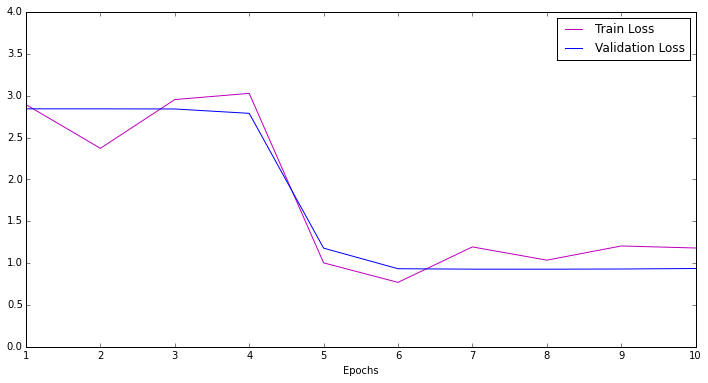

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses, epochs, min_y, max_y):
    x1 = [a+1 for (a,b)  in train_losses]
    y1 = [b for (a,b)  in train_losses]
    x2 = [a+1 for (a,b)  in val_losses]
    y2 = [b for (a,b)  in val_losses]
    plt.figure(figsize=(12, 6))
    plt.axis((1, epochs, min_y, max_y))
    plt.plot(x1, y1, "-m", x2, y2, "-b")
    plt.legend(('Train Loss', 'Validation Loss'))
    xlabel = 'Epochs'
    plt.xlabel(xlabel)
    plt.show()

plot_losses(train_losses, val_losses, 10, 0, 4.0)